In [56]:
# Parameters
experiment_config_path = None
experiment_output_dir = None
apartment_initial_conditions = None
na_growth_rate_fill_value = None

In [1]:
# # Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/experiment_example_G3.yaml'
# experiment_output_dir = '/lab/data/celldom/output/20180923-G3-full'
# # apartment_initial_conditions = ['single_cell', 'double_cell']
# apartment_initial_conditions = None
# na_growth_rate_fill_value = 0

In [2]:
assert experiment_config_path, 'Must provide value for parameter `experiment_config_path`'
assert experiment_output_dir, 'Must provide value for parameter `experiment_output_dir`'

if str(apartment_initial_conditions) == 'None':
    apartment_initial_conditions = None    
elif isinstance(apartment_initial_conditions, str):
    apartment_initial_conditions = [apartment_initial_conditions]

if str(na_growth_rate_fill_value) == 'None':
    na_growth_rate_fill_value = None
else:
    na_growth_rate_fill_value = float(na_growth_rate_fill_value)

In [3]:
%matplotlib inline
import celldom
import os
import os.path as osp
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from skimage import io
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import calculation

In [4]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)

In [5]:
# For this part of the analysis, assume that we want to examine growth rates in all
# apartments regardless of their initial conditions
print(
    'Apartment initial condition filter update: {} -> {}'.format(
        config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter'],
        apartment_initial_conditions
    )
)
config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter'] = apartment_initial_conditions

Apartment initial condition filter update: ['single_cell'] -> None


In [6]:
# Fetch apartment growth rate data (this may take a minute or two)
df = calculation.calculate_apartment_growth_rates(experiment, save=False)
df = calculation.remove_oob_apartments(experiment, df)
df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)

# Apply NA growth rate placeholder, if provided
if na_growth_rate_fill_value is not None:
    df['growth_rate'] = df['growth_rate'].fillna(na_growth_rate_fill_value)
    
# Ignore invalid growth rates (Note that the fill value above provides a way to distinguish
# between apartments with no data and apartments with conditions ineligible for growth rate calculation)
df = df[df['growth_rate'].notnull()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15582 entries, 0 to 15639
Data columns (total 20 columns):
acq_pump             15582 non-null object
acq_color            15582 non-null object
acq_condition        15582 non-null object
acq_cohort           15582 non-null object
st_num               15582 non-null object
apt_num              15582 non-null object
acq_ids              15582 non-null object
cell_counts          15582 non-null object
confluence           15582 non-null object
elapsed_hours_min    15582 non-null float64
first_count          15582 non-null float64
first_date           15582 non-null datetime64[ns]
growth_rate          15582 non-null float64
last_count           15582 non-null float64
last_date            15582 non-null datetime64[ns]
max_cell_count       15582 non-null float64
min_cell_count       15582 non-null float64
n                    15582 non-null int64
occupancies          15582 non-null object
array                15582 non-null object
dtypes: da

In [7]:
df['growth_rate'].describe()

count    15582.000000
mean         0.168783
std          0.325657
min         -1.260297
25%         -0.007287
50%          0.114106
75%          0.304316
max          1.896569
Name: growth_rate, dtype: float64

## Array Visualizations

##### Growth Rates

These heatmaps show growth rates for individual apartments where any individual growth rate may be missing due to:
- Apartment not ever identified in raw images
- Only a single cell count is present (growth rates for one time point not possible)
- Apartment does not meet the initial conditions criteria (single_cell, double_cell, etc.)

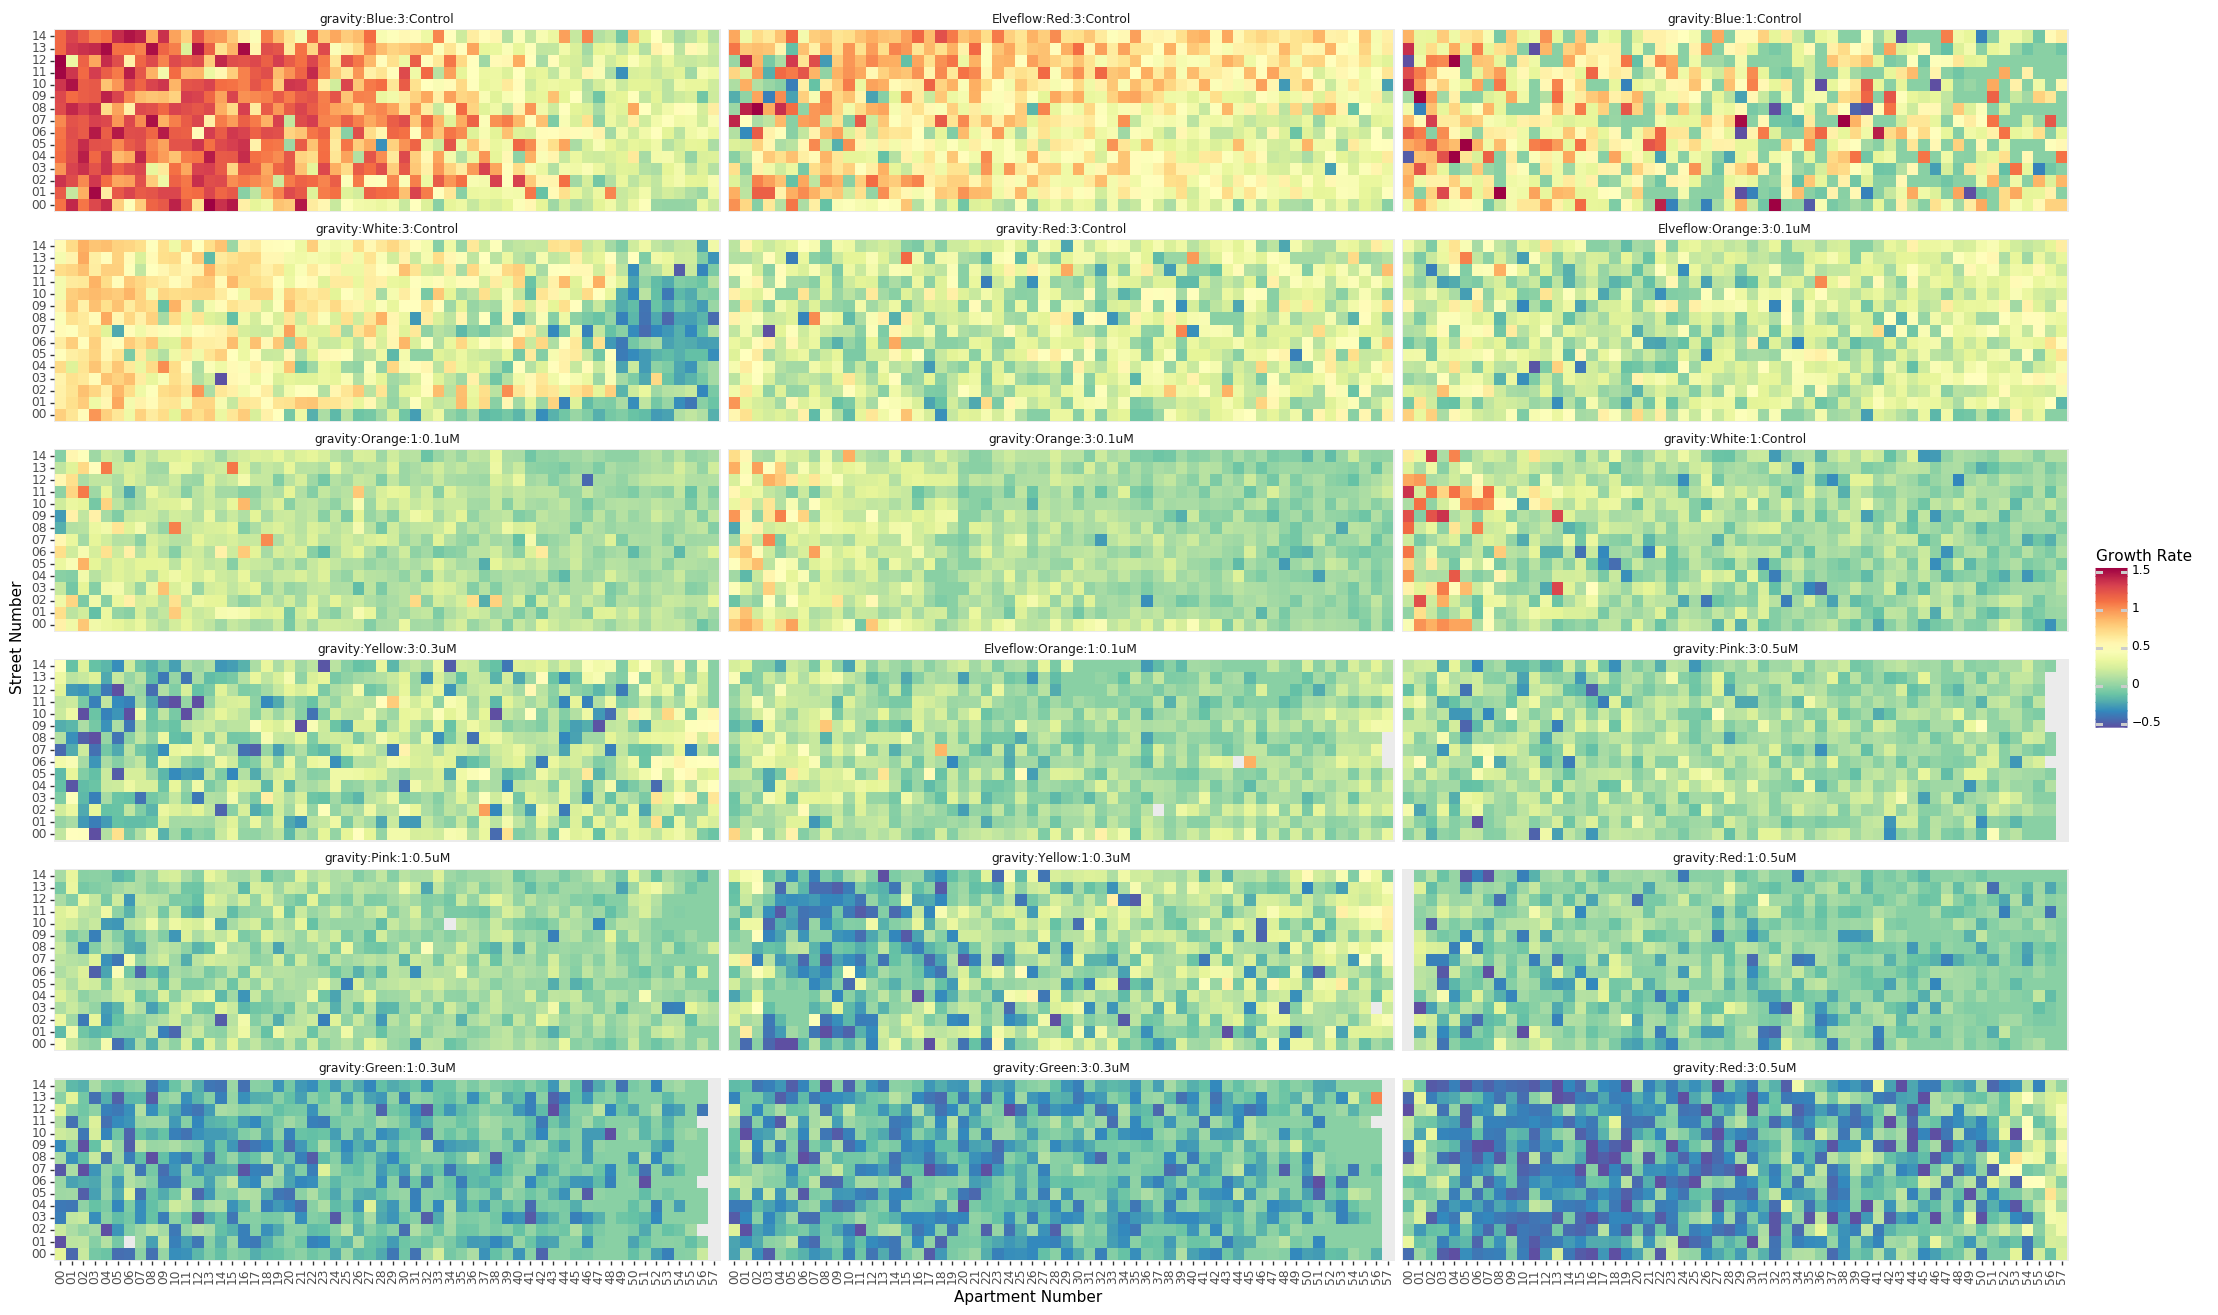

<ggplot: (-9223363281126171448)>

In [8]:
(
    pn.ggplot(
        (
            df
            .assign(array=pd.Categorical(
                df['array'], ordered=True,
                categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
            .rename(columns={'growth_rate': 'Growth Rate'})
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Growth Rate')
    ) +
    pn.geom_tile() +
    pn.scale_fill_cmap(name='Spectral_r', limits=(-.5, 1.5)) +#, guide=pn.guide_legend(title='Growth Rate')) +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26,16),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_grid_major=pn.element_blank(),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)

##### Confluence

This heatmap indicates apartments that ever reached a state of "confluence":

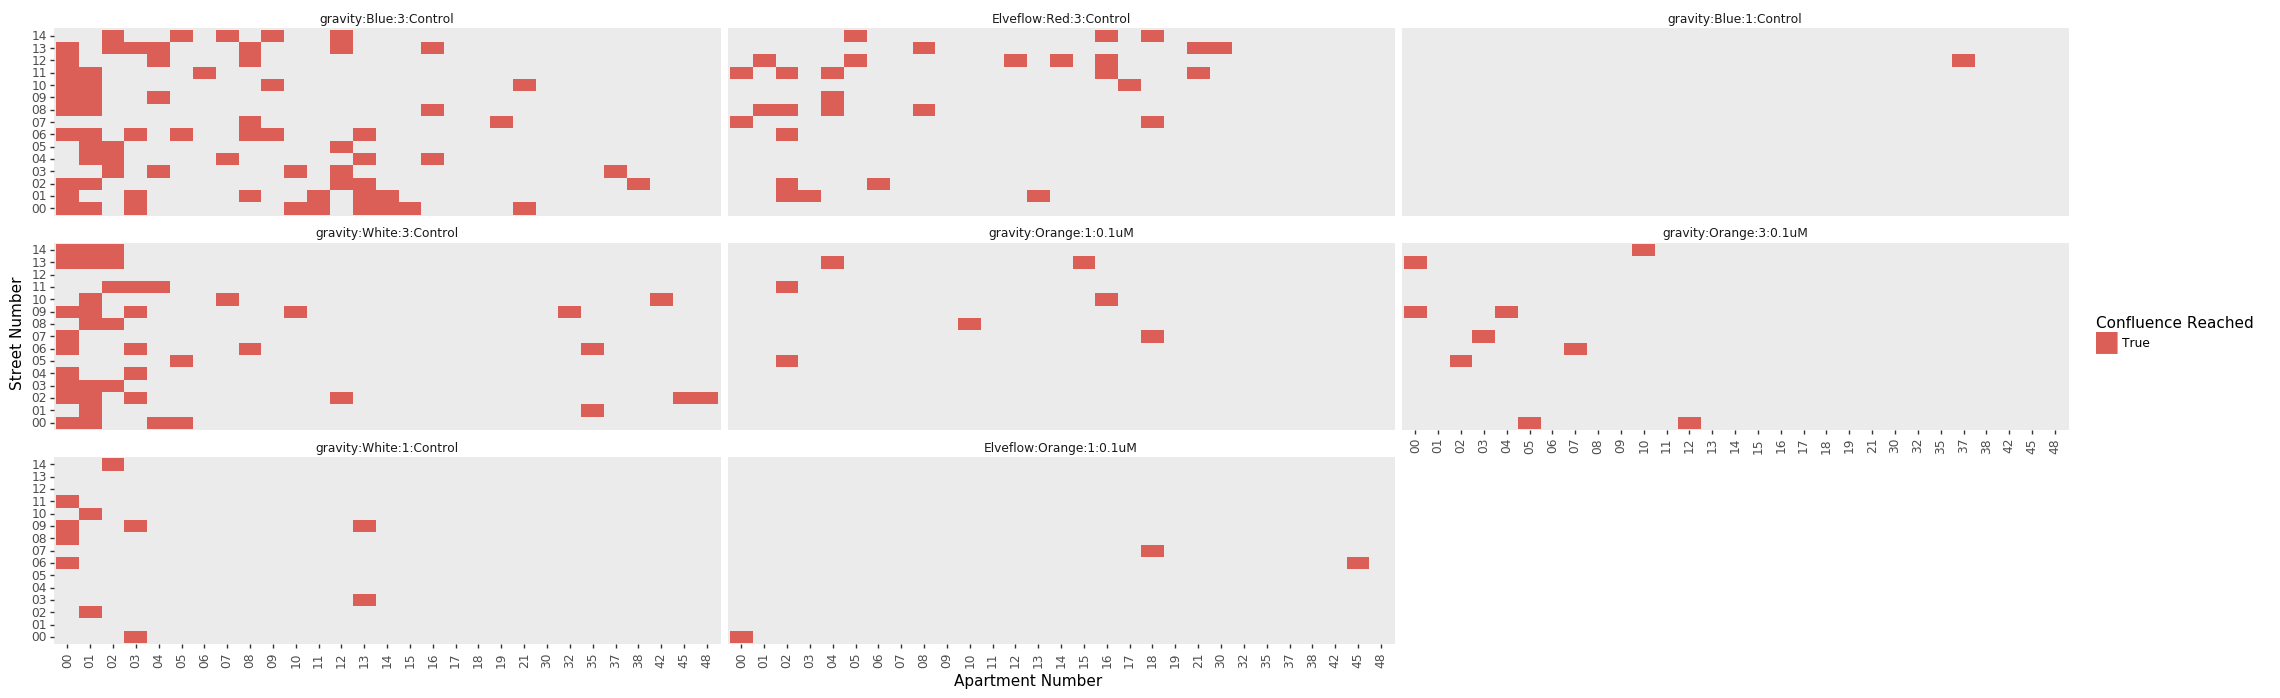

<ggplot: (8755735375273)>

In [9]:
import json
(
    pn.ggplot(
        (
            df
            .assign(confluence=df['confluence'].apply(lambda v: np.max(list(json.loads(v).values()))))
            .assign(array=pd.Categorical(
                df['array'], ordered=True,
                categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
            .loc[lambda d: d['confluence'] == True]
            .rename(columns={'confluence': 'Confluence Reached'})
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Confluence Reached')
    ) +
    pn.geom_tile() +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26,8),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_grid_major=pn.element_blank(),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)

##### Trapping Efficiency

This table shows what percentage of apartments in each array began with a single cell (as well as other cell counts):

In [11]:
def classify(ct):
    ct = int(round(ct))
    return str(ct) if ct < 5 else '5+'
dfc = (
    df
    .assign(initial_cell_count=df['first_count'].apply(classify))
    .groupby(config.experimental_condition_fields + ['initial_cell_count']).size().rename('count')
    .unstack()
)
dfn = dfc.sum(axis=1)
dfp = dfc.divide(dfn, axis=0)
dfo = pd.concat([dfp, dfn.rename('n_apartments')], axis=1)
dfo.columns.name = 'initial_cell_count'

def disp():
    if '1' in dfo:
        return (
            dfo.sort_values('1', ascending=False)
            .style.background_gradient(subset='1', cmap='RdYlGn')
            .format('{:.1%}', subset=dfp.columns)
        )
    else:
        return dfo
disp()